# These code cells will be where Engine code testing is done!
As a Jupyter notebook, it will be simpler to write down everything that I am intending to communicate

In [141]:
# Importing the packages cell
import numpy as np
import scipy as sp
import os
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-darkgrid")
current = os.getcwd()
main = "c:\APCSE"
os.chdir(main)
from AtmosphereFunction import AtmosphereFunctionSI
from AircraftDictionaries import PiperArcherIII_Dict
os.chdir(current)

So far the main source for engine data will come from the Lycoming 360 datasheet. This sheet is only accessilbe from on their website using wayback machine due to them removing the file from their site. 

First I want to find the max fuel drain during the ground roll in take-off. The throttle will be at the maximum position, so the power from the engine will be fully constant, and the fuel consumption will also be assumed to be constant. Using two data points, we are able to evaluate the fuel consumption during the ground roll.
$$\frac{\partial c}{\partial P} \approx \frac{\Delta c}{\Delta P} = \frac{79-72}{152-135}\frac{lbs}{hr\cdot hp}$$

In [212]:
lbf_to_kg = sp.constants.pound
h_to_s = sp.constants.hour
DcDP = (79-72)/(152-135)
cmax = DcDP*(180-152) + 79
cmax_Si = cmax *lbf_to_kg / h_to_s
mdot = -cmax_Si
m0 = 2550*lbf_to_kg
m = lambda t: m0 + mdot*t



dt = 10**(-2)

C_D, C_L = 0.00626, 1

T, P, rho, g, mu = AtmosphereFunctionSI(0, want = ["T", "P", "rho", "g", "mu"])
S = PiperArcherIII_Dict["Wings"]["S_wing"]

b = PiperArcherIII_Dict["Wings"]["b_wing"]
v_max = np.sqrt(2*m0*g/(rho*S*C_L))
print(v_max/ sp.constants.knot)
Re = rho*v_max/mu
Thrust = lambda v: 180*sp.constants.horsepower/v
N = lambda t, vx: m(t)*g-.5*rho*C_L*vx**2*S

66.21314344633923


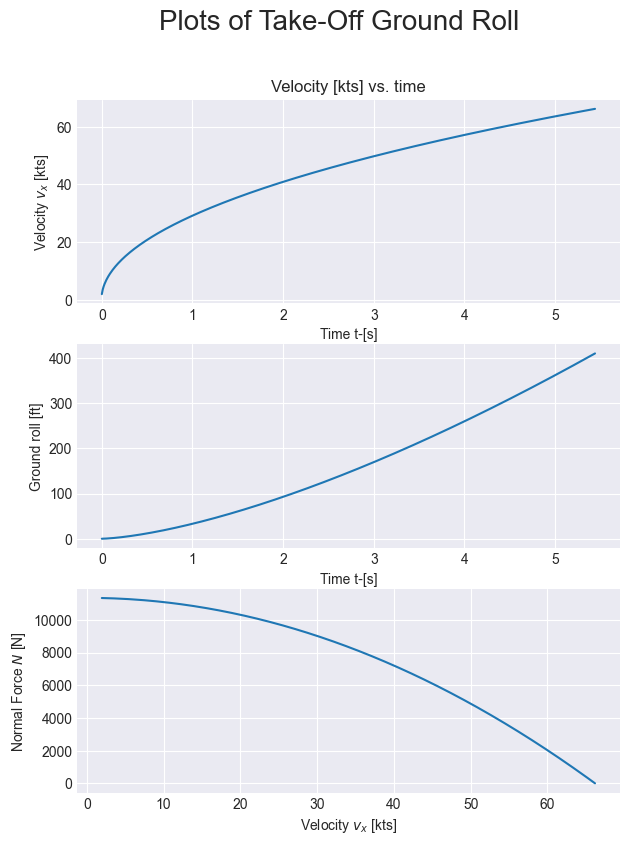

In [230]:
mu_f = 0.04
def TakeOff_ODE(Dot, t):
    v_x, v_y, v_z, x, y, z = Dot
    dv_xdt = 1/m(t)*(Thrust(v_x)-.5*rho*S*C_D*v_x**2-(m(t)*g-.5*rho*C_L*v_x**2)*mu_f)
    dv_ydt = 0
    dv_zdt = 0
    dxdt = v_x
    dydt = v_y
    dzdt = v_z
    return [dv_xdt, dv_ydt, dv_zdt, dxdt, dydt, dzdt]

t_arr = np.arange(0,100, dt)

initial = np.array([1,0,0,0,0,0])

solution = sp.integrate.odeint(TakeOff_ODE, initial, t_arr)

vx = solution[:,0]
vy = solution[:,1]
vz = solution[:,2]
x = solution[:,3]
y = solution[:,4]
z = solution[:,5]
NormalArr = N(t_arr, vx)

fig = plt.figure(figsize=(7,9))


vplot = fig.add_subplot(311)
vplot.plot(t_arr[NormalArr > 0], vx[NormalArr > 0]/sp.constants.knot)
vplot.set_xlabel("Time t-[s]")
vplot.set_ylabel("Velocity $v_x$ [kts]")
vplot.set_title("Velocity [kts] vs. time")

xplot = fig.add_subplot(312)
xplot.plot(t_arr[NormalArr > 0], x[NormalArr > 0]/sp.constants.foot)
xplot.set_xlabel("Time t-[s]")
xplot.set_ylabel("Ground roll [ft]")

Nplot = fig.add_subplot(313)
Nplot.plot(vx[NormalArr > 0]/sp.constants.knot, NormalArr[NormalArr > 0])
Nplot.set_xlabel("Velocity $v_x$ [kts]")
Nplot.set_ylabel("Normal Force $N$ [N]")
fig.suptitle("Plots of Take-Off Ground Roll", fontsize = 20)

fig.savefig("TakeOff_test_plots.png")

In [185]:
vx/sp.constants.knot

array([ 1.94384449,  1.95628697,  1.96872944, ..., 20.51933199,
       20.53167957, 20.54402703])